<a href="https://colab.research.google.com/github/JakobSchauser/MLandData/blob/main/tree/main/MachineLearningA/Home%2520Assignment%25206/Torch_Traffic_Signs_Basic_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic CNN for traffic sign recognition
## Christian Igel, 2021

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

Please [contact me](mailto:igel@diku.dk) if you have suggestions for improving the notebook.

Do the imports first:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

Check if a GPU is available:

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


The GTSRB data wrapped in a `Dataset`:

In [3]:
class GTSRBTrafficSigns(Dataset):
  def __init__(self, root = './', url = 'https://sid.erda.dk/share_redirect/EB0rrpZwuI', filename='EB0rrpZwuI.zip', train=True, force_download=False): 
    self.img_height  = 32  
    self.img_width   = self.img_height
    self.img_height_crop = 28  
    self.img_width_crop  = self.img_height_crop

    self.train = train
    archive = os.path.join(root, filename)

    if self.train:
      self.data_folder = os.path.join(root, 'GTSRB/train')
    else:
      self.data_folder = os.path.join(root, 'GTSRB/test')

    if (not os.path.exists(self.data_folder)) or force_download:
       download_url(url, root, filename)
       extract_archive(archive, root, False)
    else:
      print('Using existing', self.data_folder)

    self.dataset_train = datasets.ImageFolder(self.data_folder)

  def __getitem__(self, index):
      image, label = self.dataset_train.__getitem__(index)
      image = transforms.Resize((self.img_width,self.img_height))(image)
      
      if self.train:
        image = transforms.RandomAffine((-5,5))(image)
        image = transforms.RandomCrop((self.img_width_crop, self.img_height_crop))(image)
        #image = transforms.ColorJitter(0.8, contrast = 0.4)(image)
        if label in [11, 12, 13, 17, 18, 26, 30, 35]:
          image = transforms.RandomHorizontalFlip(p=0.5)(image)
      else:
        image = transforms.CenterCrop((self.img_width_crop, self.img_height_crop))(image)

      image = transforms.ToTensor()(image)

      return image, label

  def __len__(self):
      return self.dataset_train.__len__()

In [4]:
dataset_train = GTSRBTrafficSigns()

  0%|          | 0/290897892 [00:00<?, ?it/s]

Define the data loader for training:

In [5]:
batch_size = 128
generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's visualize some input images. This visualization is very important, among others to verify that the data augmentation works as expected.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


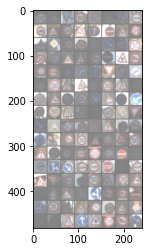

In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(generator_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Let's look at each image in the batch with its label:

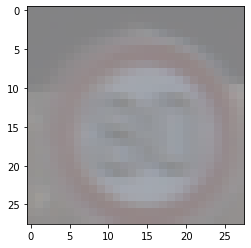

5 




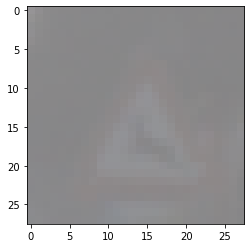

31 




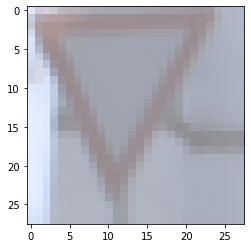

13 




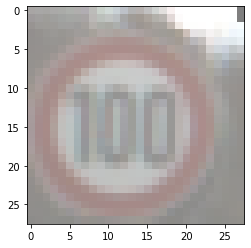

7 




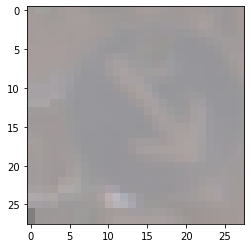

38 




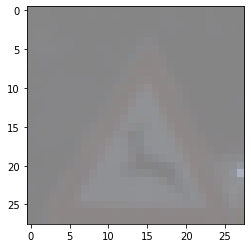

31 




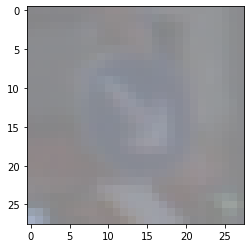

38 




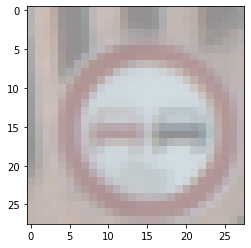

9 




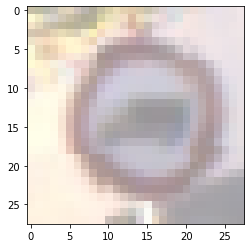

16 




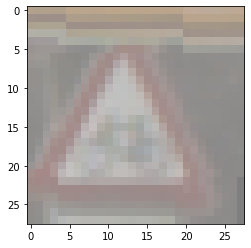

29 




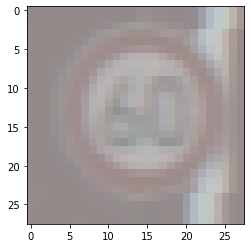

3 




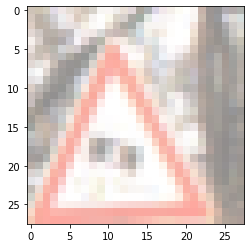

23 




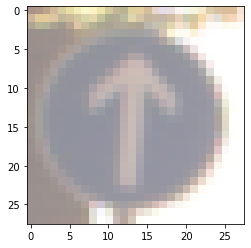

35 




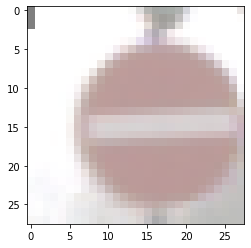

17 




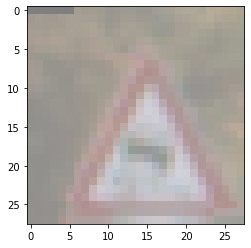

23 




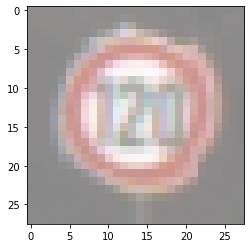

8 




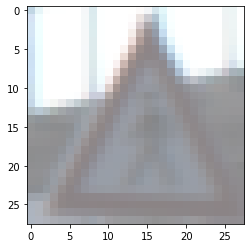

27 




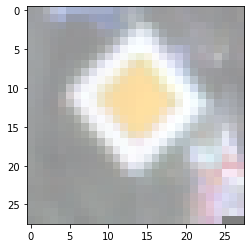

12 




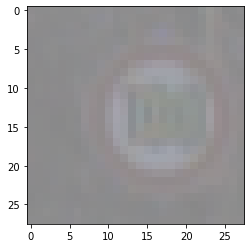

7 




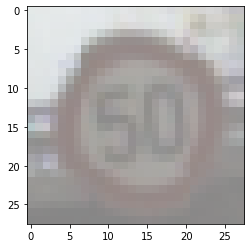

2 




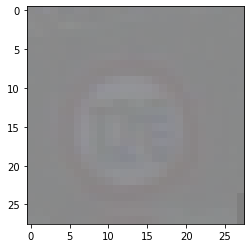

8 




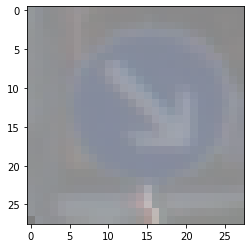

38 




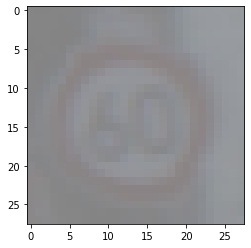

3 




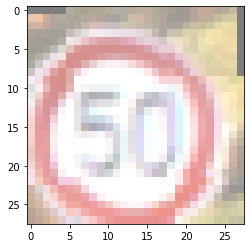

2 




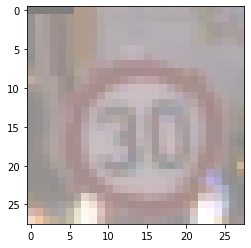

1 




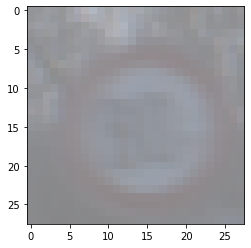

5 




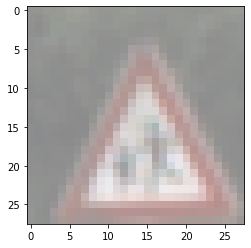

28 




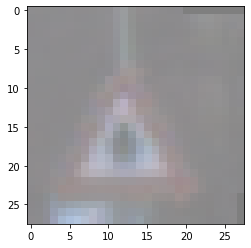

11 




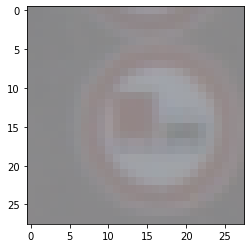

10 




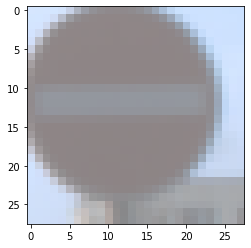

17 




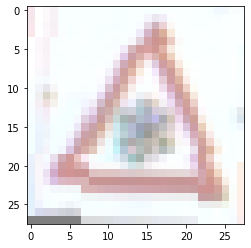

30 




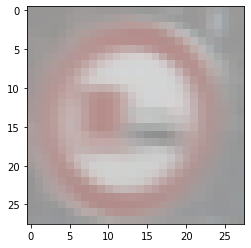

10 




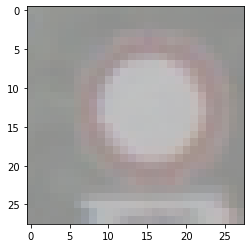

15 




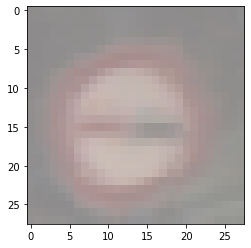

9 




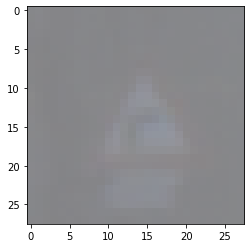

20 




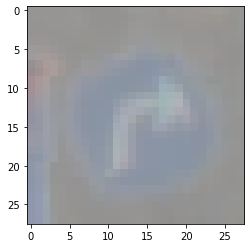

33 




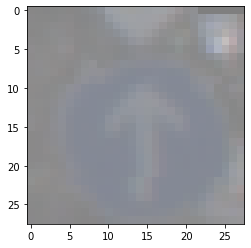

35 




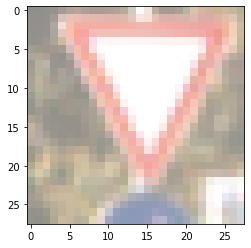

13 




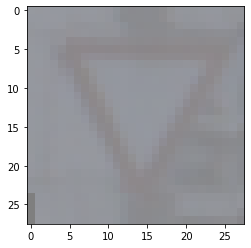

13 




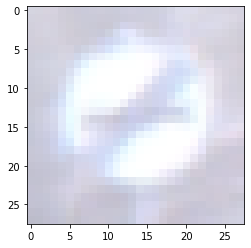

41 




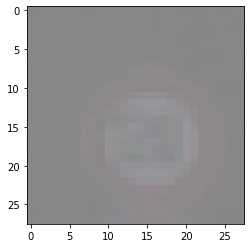

8 




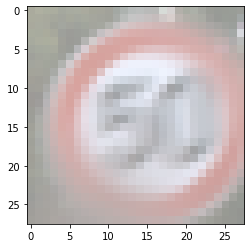

2 




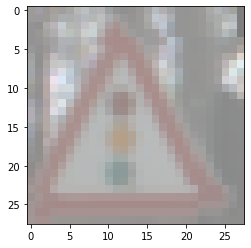

26 




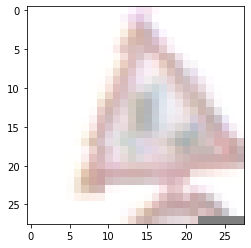

25 




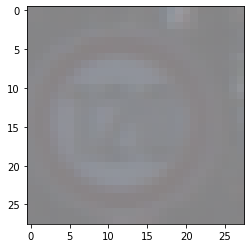

8 




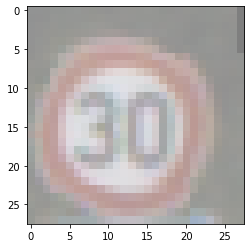

1 




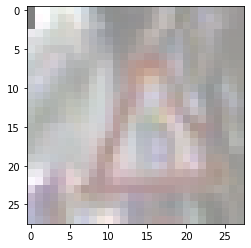

24 




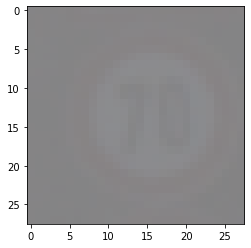

4 




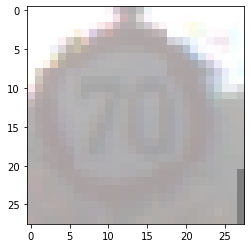

4 




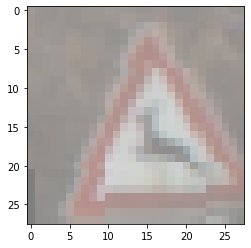

31 




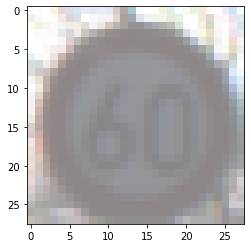

3 




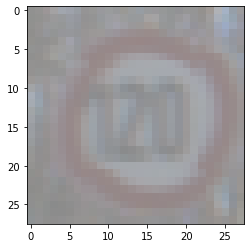

8 




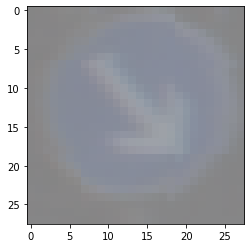

38 




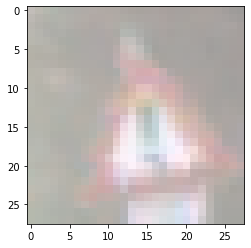

18 




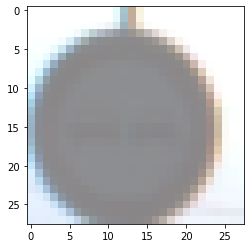

9 




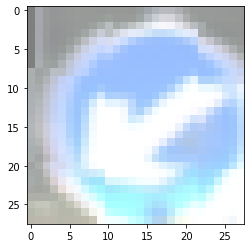

39 




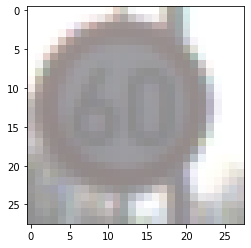

3 




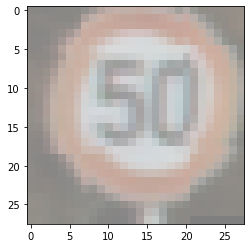

2 




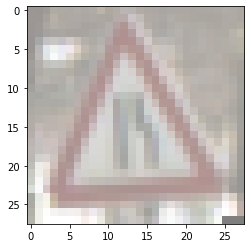

24 




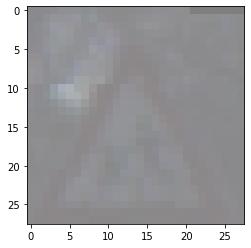

28 




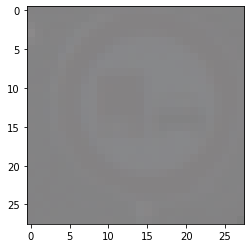

10 




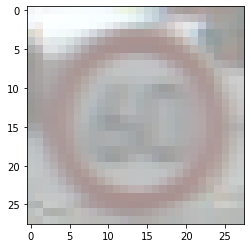

3 




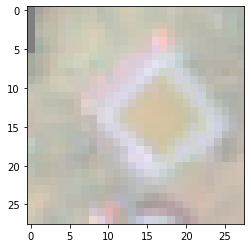

12 




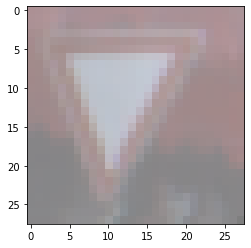

13 




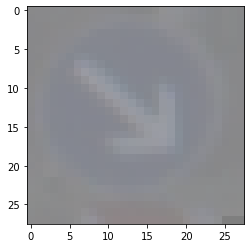

38 




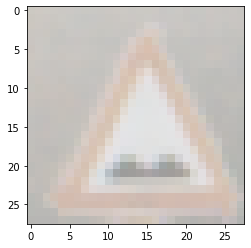

22 




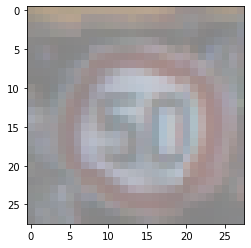

2 




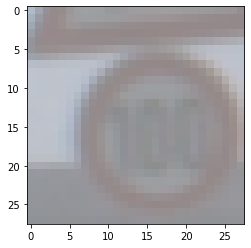

7 




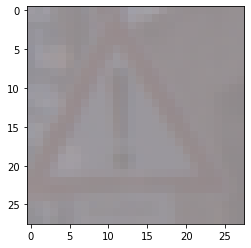

18 




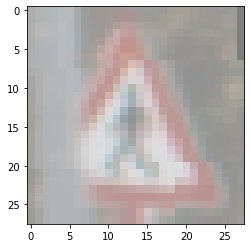

27 




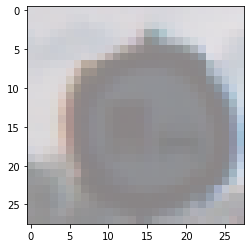

10 




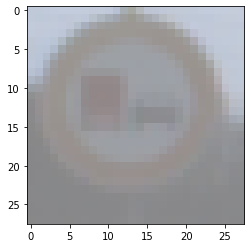

10 




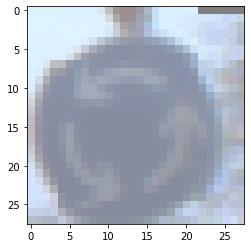

40 




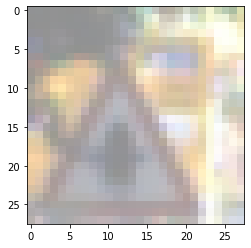

11 




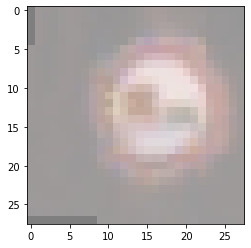

10 




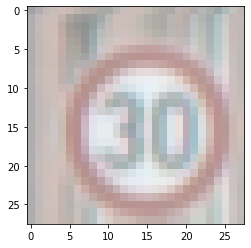

1 




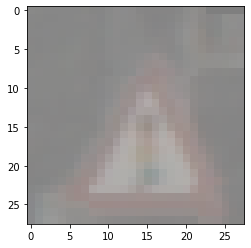

26 




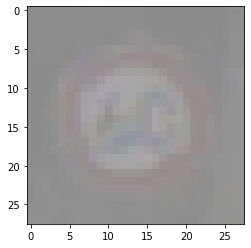

3 




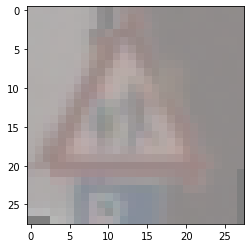

28 




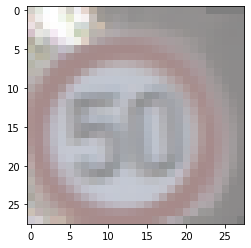

2 




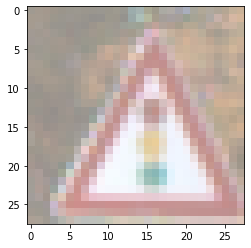

26 




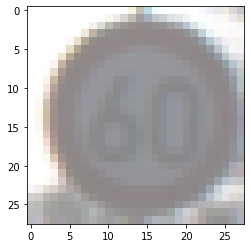

3 




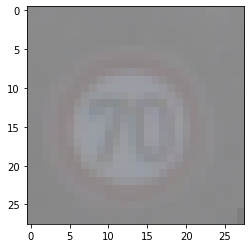

4 




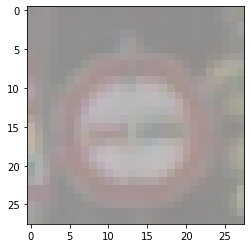

9 




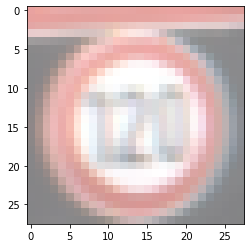

8 




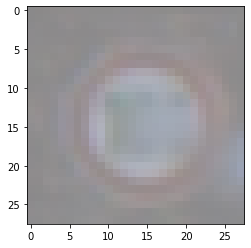

7 




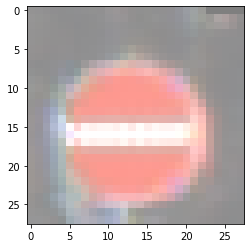

17 




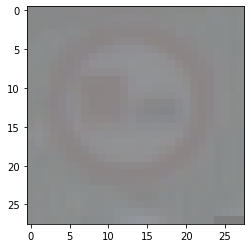

10 




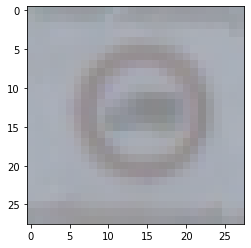

16 




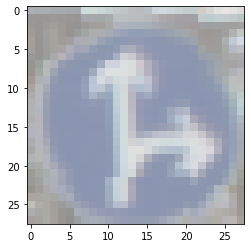

36 




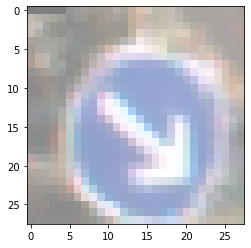

38 




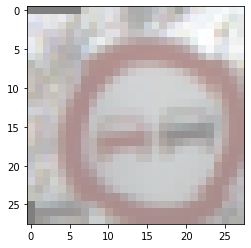

9 




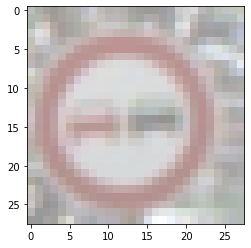

9 




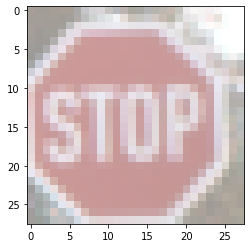

14 




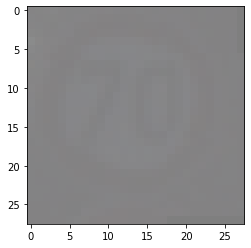

4 




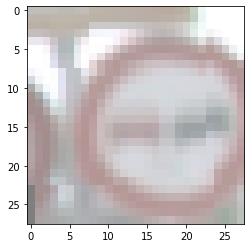

9 




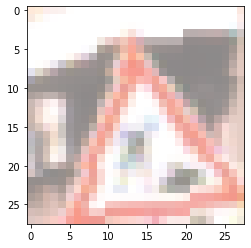

25 




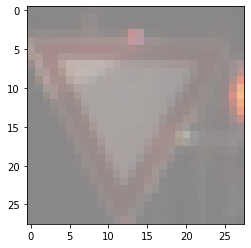

13 




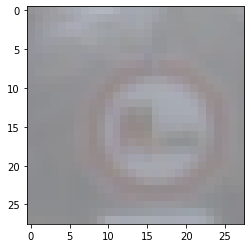

10 




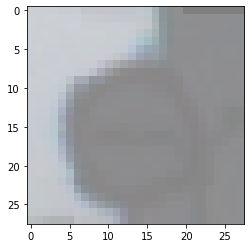

9 




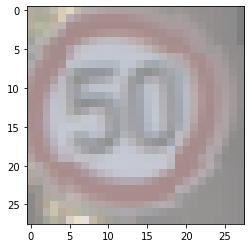

2 




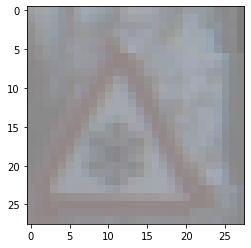

30 




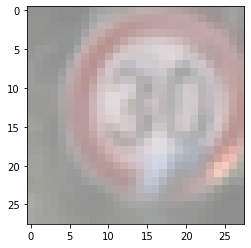

1 




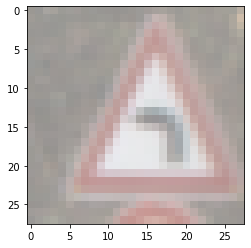

19 




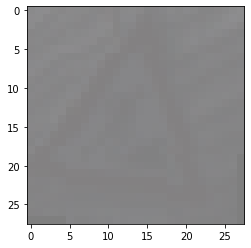

25 




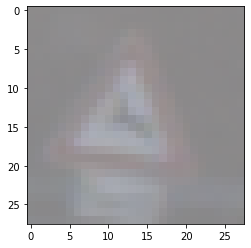

31 




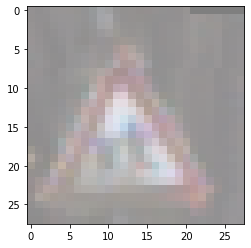

28 




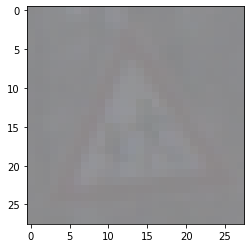

28 




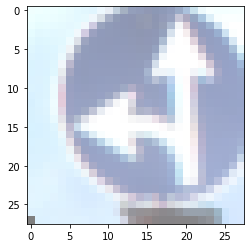

37 




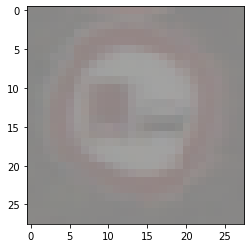

10 




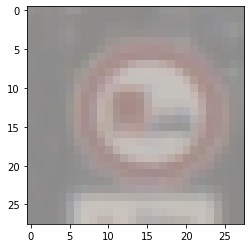

10 




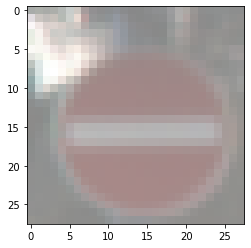

17 




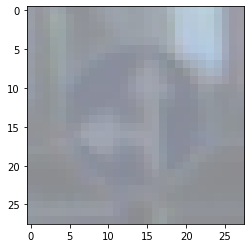

37 




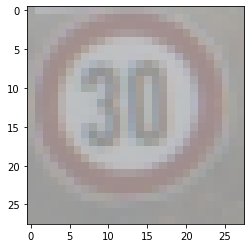

1 




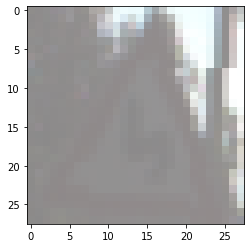

21 




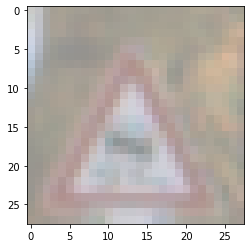

23 




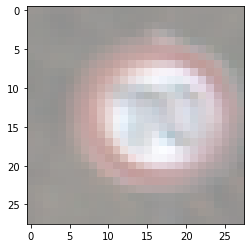

4 




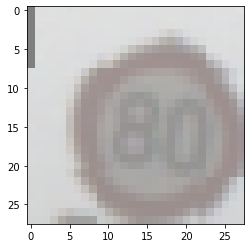

5 




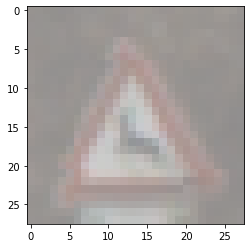

31 




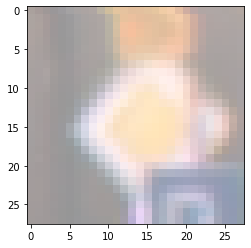

12 




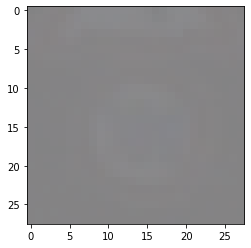

7 




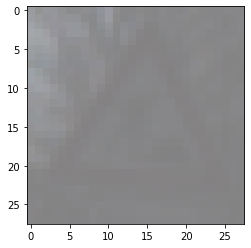

25 




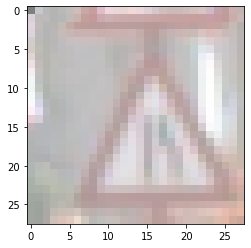

24 




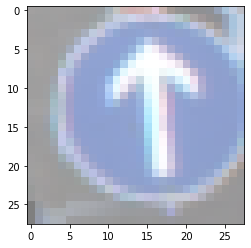

35 




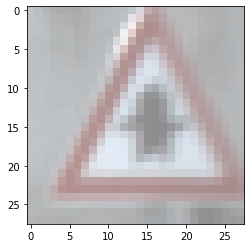

11 




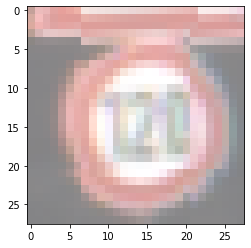

8 




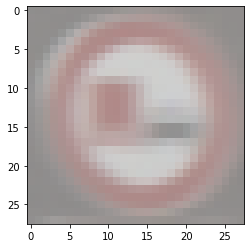

10 




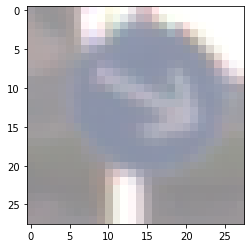

38 




In [7]:
for i in range(batch_size):
  imshow(images[i])
  print(labels[i].item(), "\n\n")


Define the neural network:

In [22]:
in_channels = 3

class Net(nn.Module):
    def __init__(self, img_size=28):
        super(Net, self).__init__()

        # self.convs = nn.ModuleList([nn.Conv2d(in_channels,64,(5,5),stride = (1,1)),nn.Conv2d(64,64,(5,5),stride = (1,1))])

        # self.pools = nn.ModuleList([nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)])
        
        self.conv1, self.conv2 = nn.Conv2d(in_channels,64,(5,5),stride = (1,1)),nn.Conv2d(64,64,(5,5),stride = (1,1))
        self.pool1, self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.out = nn.Linear(1024,43)



    def forward(self, x):
        # for c,p in zip(self.convs,self.pools):
        #   x = c(x)
        #   x = p(x)

        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv1(x)
        x = self.pool2(x)


        return self.out(x)



Instantiate the neural network and potentially move it to GPU:

In [23]:
net = Net()
if(gpu):
  net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (out): Linear(in_features=1024, out_features=43, bias=True)
)


Define loss and optimization algorithm:

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)

These lines can be used to continue training:

In [25]:
cont = False
if cont:
  net.load_state_dict(torch.load('traffic_simple'))

Do the training:

In [26]:
net = Net()
if(gpu):
  net.to(device)

no_epochs = 200
for epoch in range(no_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(generator_train, 0):
        # Get the inputs; data is a list of [inputs, labels]

        if (gpu):
          inputs, labels = data[0].to(device), data[1].to(device)
        else:
          inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        reporting_interval = 100
        running_loss += loss.item()
        if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / reporting_interval))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

Evaluate on test set:

In [ ]:
dataset_test = GTSRBTrafficSigns(train=False)
generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

correct = 0
total = 0
with torch.no_grad():
    for data in generator_test:
        if (gpu):
          images, labels = data[0].to(device), data[1].to(device)
        else:
          images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Save network:

In [ ]:
torch.save(net.state_dict(), 'traffic_simple')